use nn.lstm package to ensemble the LSTM

In [13]:
!nvidia-smi

Sun Nov  1 16:27:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    41W / 250W |    885MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
CUDA_LAUNCH_BLOCKING=1

Import Package
=======================

In [2]:
pip install pytorch-nlp

     |████████████████████████████████| 92kB 2.4MB/s 


In [3]:
import torch
from torchnlp.word_to_vector import GloVe
from torch import nn, optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.autograd.variable import Variable
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

Import dataset
=========================

In [4]:
numwords = 50000
max = 200
from tensorflow.keras.datasets import imdb
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) \
= imdb.load_data(num_words=numwords, seed=500)
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items() if i < numwords}

1646592/1641221 [==============================] - 0s 0us/step


In [5]:
# Y_train = torch.from_numpy(Y_train_numpy).type(torch.float)
# Y_test = torch.from_numpy(Y_test_numpy).type(torch.float)
Y_train = torch.from_numpy(Y_train_numpy).type(torch.float).cuda()
Y_test = torch.from_numpy(Y_test_numpy).type(torch.float).cuda()
print(f"Y_train is {Y_train.size()}, Y_test is {Y_test.size()}")

Y_train is torch.Size([25000]), Y_test is torch.Size([25000])


remove stop words and trivial words
------------------------
first we get id of all stop words

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)
stop_words_id = [word2id.get(i, 0) for i in stop_words]
print(stop_words_id)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

remove stop words on train and test set

In [7]:
# remove stop words on train set
X_train_numpy_rm_stopwords = []
for comment in X_train_numpy:
    X_train_numpy_rm_stopwords.append([w for w in comment if w not in stop_words_id])
    # print([w for w in comment if w not in stop_words_id])
X_train_numpy_rm_stopwords = np.array(X_train_numpy_rm_stopwords)

# remove stop words on test set
X_test_numpy_rm_stopwords = []
for comment in X_test_numpy:
    X_test_numpy_rm_stopwords.append([w for w in comment if w not in stop_words_id])
    # print([w for w in comment if w not in stop_words_id])
X_test_numpy_rm_stopwords = np.array(X_test_numpy_rm_stopwords)

calculate the word frequency of both side

In [8]:
neg_word_freq = {}
pos_word_freq = {}
for comment_id, comment in enumerate(X_train_numpy_rm_stopwords):
    if Y_train_numpy[comment_id] == 0: # this comment is negative
        for w in comment:
            neg_word_freq[w] = neg_word_freq.get(w, 0) + 1
    elif Y_train_numpy[comment_id] == 1: # this comment is positive
        for w in comment:
            pos_word_freq[w] = pos_word_freq.get(w, 0) + 1

# sort them
neg_word_freq_sort = sorted(neg_word_freq.items(), key=lambda x: x[1], reverse=True)
pos_word_freq_sort = sorted(pos_word_freq.items(), key=lambda x: x[1], reverse=True)

check the freq of both side

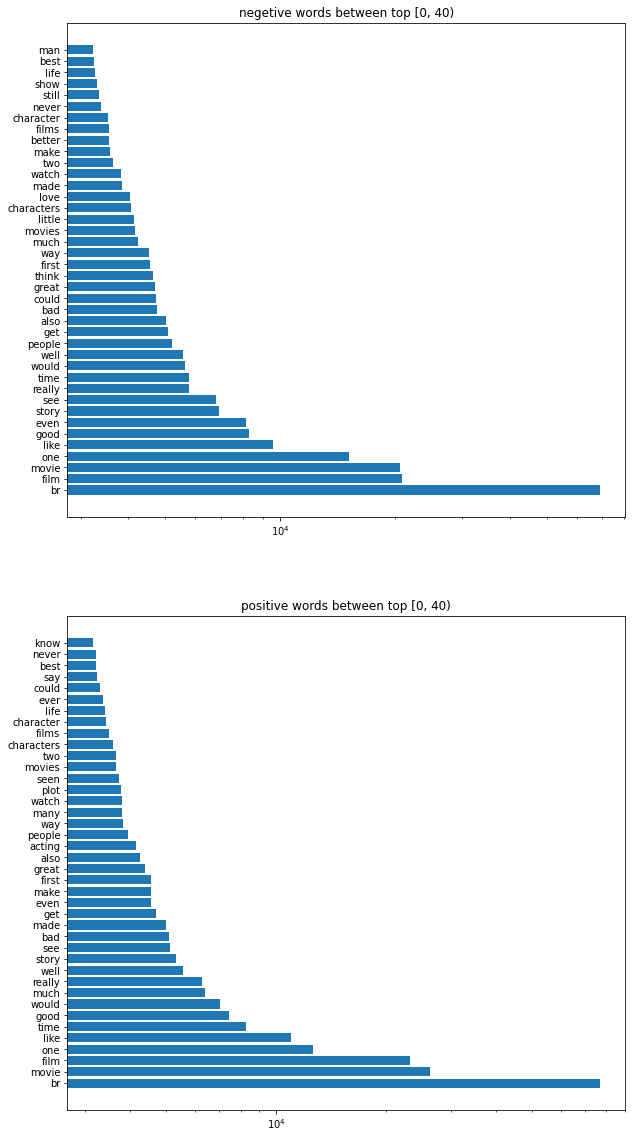

In [9]:
(low_bd, high_bd) = (0, 40)
neg = [(id2word[item[0]], item[1]) for i, item in enumerate(neg_word_freq_sort) if i < high_bd and i >= low_bd]
pos = [(id2word[item[0]], item[1]) for i, item in enumerate(pos_word_freq_sort) if i < high_bd and i >= low_bd]

plt.figure(figsize=(10,20))
plt.subplot(2, 1, 1)
plt.barh([x[0] for x in neg], [x[1] for x in neg], log=True)
plt.title(f"negetive words between top [{low_bd}, {high_bd})")
plt.subplot(2, 1, 2)
plt.barh([x[0] for x in pos], [x[1] for x in pos], log=True)
plt.title(f"positive words between top [{low_bd}, {high_bd})")
plt.show()

remove trivial words ```['br', 'movie', 'film', 'one', 'character', 'movies']```

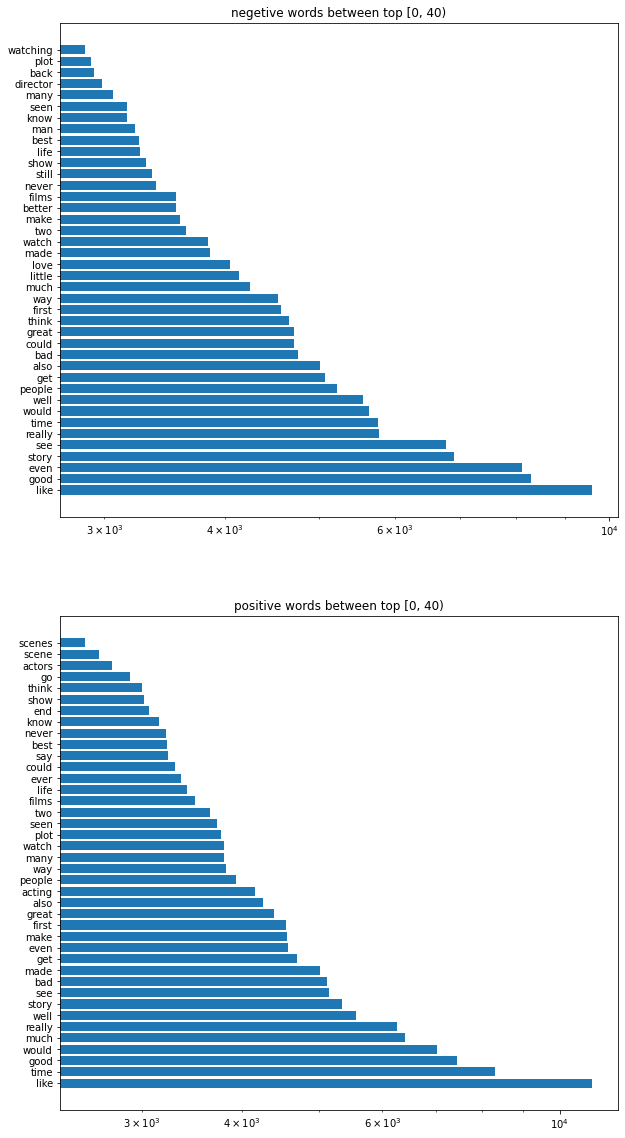

In [10]:
# define trivial words
trivial_words_id = [word2id.get(i, 0) for i in ['br', 'movie', 'film', 'one', 'character', 'movies', 'characters']]

# remove trivial words on train set
X_train_numpy_clean = []
for comment in X_train_numpy_rm_stopwords:
    X_train_numpy_clean.append([w for w in comment if w not in trivial_words_id])
    # print([w for w in comment if w not in stop_words_id])
X_train_numpy_clean = np.array(X_train_numpy_clean)

# remove trivial words on test set
X_test_numpy_clean = []
for comment in X_test_numpy_rm_stopwords:
    X_test_numpy_clean.append([w for w in comment if w not in trivial_words_id])
    # print([w for w in comment if w not in stop_words_id])
X_test_numpy_clean = np.array(X_test_numpy_clean)

# word frequency on train set
neg_word_freq = {}
pos_word_freq = {}
for comment_id, comment in enumerate(X_train_numpy_clean):
    if Y_train_numpy[comment_id] == 0: # this comment is negative
        for w in comment:
            neg_word_freq[w] = neg_word_freq.get(w, 0) + 1
    elif Y_train_numpy[comment_id] == 1: # this comment is positive
        for w in comment:
            pos_word_freq[w] = pos_word_freq.get(w, 0) + 1

# sort them
neg_word_freq_sort = sorted(neg_word_freq.items(), key=lambda x: x[1], reverse=True)
pos_word_freq_sort = sorted(pos_word_freq.items(), key=lambda x: x[1], reverse=True)

# plot
(low_bd, high_bd) = (0, 40)
neg = [(id2word[item[0]], item[1]) for i, item in enumerate(neg_word_freq_sort) if i < high_bd and i >= low_bd]
pos = [(id2word[item[0]], item[1]) for i, item in enumerate(pos_word_freq_sort) if i < high_bd and i >= low_bd]

plt.figure(figsize=(10,20))
plt.subplot(2, 1, 1)
plt.barh([x[0] for x in neg], [x[1] for x in neg], log=True)
plt.title(f"negetive words between top [{low_bd}, {high_bd})")
plt.subplot(2, 1, 2)
plt.barh([x[0] for x in pos], [x[1] for x in pos], log=True)
plt.title(f"positive words between top [{low_bd}, {high_bd})")
plt.show()

the comparison of word cleaning

In [11]:
for i in range(100):
    print((len(X_train_numpy[i]), len(X_train_numpy_clean[i])))

(585, 317)
(203, 93)
(134, 51)
(552, 281)
(111, 47)
(159, 71)
(900, 447)
(27, 15)
(169, 84)
(236, 103)
(123, 68)
(65, 30)
(1034, 560)
(200, 119)
(116, 44)
(116, 51)
(134, 51)
(88, 39)
(140, 52)
(91, 40)
(231, 121)
(68, 43)
(102, 42)
(119, 53)
(190, 88)
(223, 98)
(256, 133)
(203, 95)
(107, 69)
(38, 19)
(127, 53)
(36, 15)
(768, 410)
(306, 136)
(194, 82)
(68, 31)
(1021, 456)
(75, 30)
(281, 131)
(122, 55)
(119, 55)
(158, 70)
(122, 46)
(135, 64)
(50, 20)
(236, 138)
(133, 72)
(180, 85)
(250, 128)
(312, 152)
(228, 111)
(142, 66)
(291, 133)
(586, 332)
(344, 167)
(114, 58)
(107, 42)
(121, 60)
(248, 111)
(205, 82)
(433, 217)
(166, 95)
(199, 74)
(74, 24)
(166, 73)
(114, 41)
(232, 106)
(707, 359)
(223, 117)
(75, 27)
(179, 83)
(52, 18)
(149, 73)
(211, 84)
(194, 91)
(151, 76)
(301, 135)
(209, 118)
(159, 65)
(713, 368)
(339, 175)
(499, 289)
(679, 317)
(179, 80)
(536, 343)
(111, 50)
(646, 329)
(115, 53)
(522, 210)
(116, 50)
(127, 57)
(334, 183)
(240, 97)
(1011, 569)
(120, 66)
(157, 85)
(160, 75)
(142,

Import Glove
===========================

In [12]:
glove = GloVe(name='6B', dim=50)

glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|██████████| 400000/400000 [00:17<00:00, 23162.80it/s]


In [ ]:
glove['cat', 'dog']

tensor([[ 0.4528, -0.5011, -0.5371, -0.0157,  0.2219,  0.5460, -0.6730, -0.6891,
          0.6349, -0.1973,  0.3368,  0.7735,  0.9009,  0.3849,  0.3837,  0.2657,
         -0.0806,  0.6109, -1.2894, -0.2231, -0.6158,  0.2170,  0.3561,  0.4450,
          0.6089, -1.1633, -1.1579,  0.3612,  0.1047, -0.7832,  1.4352,  0.1863,
         -0.2611,  0.8328, -0.2312,  0.3248,  0.1449, -0.4455,  0.3350, -0.9595,
         -0.0975,  0.4814, -0.4335,  0.6945,  0.9104, -0.2817,  0.4164, -1.2609,
          0.7128,  0.2378],
        [ 0.1101, -0.3878, -0.5762, -0.2771,  0.7052,  0.5399, -1.0786, -0.4015,
          1.1504, -0.5678,  0.0039,  0.5288,  0.6456,  0.4726,  0.4855, -0.1841,
          0.1801,  0.9140, -1.1979, -0.5778, -0.3799,  0.3361,  0.7720,  0.7556,
          0.4551, -1.7671, -1.0503,  0.4257,  0.4189, -0.6833,  1.5673,  0.2768,
         -0.6171,  0.6464, -0.0770,  0.3712,  0.1308, -0.4514,  0.2540, -0.7439,
         -0.0862,  0.2407, -0.6482,  0.8355,  1.2502, -0.5138,  0.0422, -0.8812,


In [ ]:
l = [id2word[id] for id in X_train_numpy_clean[1]]
input = glove[[id2word[id] for id in X_train_numpy_clean[1]]]
input.size()

torch.Size([93, 50])

LSTM Module
=======================
1. input_size = feature dim of word vector, here we use glove
(dim=50) so input_size = 50  
2. input: [1, word_num, input_size] = [batch, seq_len, input_size]

uni-direction
--------------

In [17]:
class LSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0, ishidden=True):
        super(LSTM1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.ishidden = ishidden
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=self.dropout)
        self.logr = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, input, hidden, state):  # input: batch, seq_len, input_size
        input = input.view(1, input.size()[0], input.size()[1])
        output, (hn, cn) = self.lstm(input, (hidden, state))
        if self.ishidden:
            output = hn.view(1, -1)
            output = self.logr(output).view(1)
        else:
            output = torch.mean(output, [0, 1])
            output = self.logr(output).view(1)
        
        return output

    def initHiddenState(self):
        return torch.zeros(self.hidden_size * self.num_layers).view(self.num_layers, 1, -1).cuda(), \
        torch.zeros(self.hidden_size * self.num_layers).view(self.num_layers, 1, -1).cuda()

bi-direction
--------------------

In [38]:
class BiLSTM1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0, ishidden=True):
        super(BiLSTM1, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.ishidden = ishidden
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=self.dropout, bidirectional=True)
        self.logr = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, input, hidden, state):  # input: batch, seq_len, input_size
        input = input.view(1, input.size()[0], input.size()[1])
        output, (hn, cn) = self.lstm(input, (hidden, state))
        if self.ishidden:
            output = hn.view(1, -1)
            output = self.logr(output).view(1)
        else:
            output0 = output[:,:,0:self.hidden_size]
            output1 = output[:,:,self.hidden_size:]
            output0 = torch.mean(output0, [0, 1])
            output1 = torch.mean(output1, [0, 1])
            output = output0 + output1
            output = self.logr(output).view(1)
        
        return output

    def initHiddenState(self):
        return torch.zeros(self.hidden_size * self.num_layers * 2).view(self.num_layers * 2, 1, -1).cuda(), \
        torch.zeros(self.hidden_size * self.num_layers * 2).view(self.num_layers * 2, 1, -1).cuda()

In [37]:
bilstm1 = BiLSTM1(50, 53, 1, 1, ishidden=False).cuda()
h_0, s_0 = bilstm1.initHiddenState()
input = glove[[id2word[id] for id in X_train_numpy_clean[7]]].cuda()
output = bilstm1(input, h_0, s_0)
output.size()

torch.Size([1])

Implement
=================
Focus on these features  
```[unidirectional(0) / bidirectional(1);1 hidden layer (0) / 2 hidden layers (1), dropout(0) / dropout 0.2 (0) ]```

**unidirectional, 1 hidden layer, dropout 0**
--------------------
train



epoch is 199, acc_rate is 0.62, loss is 0.22636889934539794
epoch is 399, acc_rate is 0.7, loss is 0.19768704729154707
epoch is 599, acc_rate is 0.66, loss is 0.20351721740007633
epoch is 799, acc_rate is 0.84, loss is 0.135873239368957
epoch is 999, acc_rate is 0.8, loss is 0.15646135502902325
epoch is 1199, acc_rate is 0.78, loss is 0.14163167163091203
epoch is 1399, acc_rate is 0.74, loss is 0.17965782580256928
epoch is 1599, acc_rate is 0.8, loss is 0.1275932312047371
epoch is 1799, acc_rate is 0.8, loss is 0.1229556212138192
epoch is 1999, acc_rate is 0.78, loss is 0.15020703660360596
epoch is 2199, acc_rate is 0.88, loss is 0.10519097555019023
epoch is 2399, acc_rate is 0.84, loss is 0.15354826853097392
epoch is 2599, acc_rate is 0.84, loss is 0.10985683200886541
epoch is 2799, acc_rate is 0.82, loss is 0.11184777768033684
epoch is 2999, acc_rate is 0.84, loss is 0.1267890795413223
epoch is 3199, acc_rate is 0.84, loss is 0.09342546165596957
epoch is 3399, acc_rate is 0.82, loss 

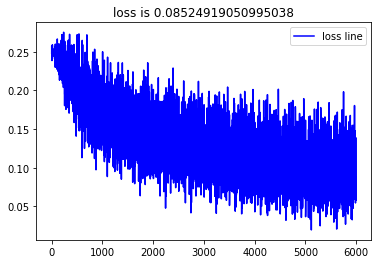

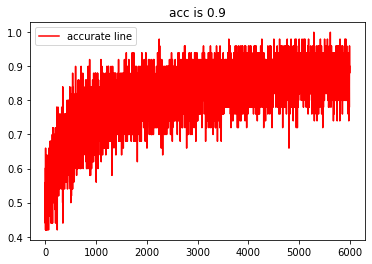

epoch is 199, acc_rate is 0.62, loss is 0.22450631037354468
epoch is 399, acc_rate is 0.72, loss is 0.19878033108077944
epoch is 599, acc_rate is 0.7, loss is 0.18609666705495329
epoch is 799, acc_rate is 0.76, loss is 0.15914772444346453
epoch is 999, acc_rate is 0.7, loss is 0.16378668791701784
epoch is 1199, acc_rate is 0.78, loss is 0.14081195207495512
epoch is 1399, acc_rate is 0.8, loss is 0.1282087133776804
epoch is 1599, acc_rate is 0.82, loss is 0.10567422736308146
epoch is 1799, acc_rate is 0.9, loss is 0.09454629841698078
epoch is 1999, acc_rate is 0.86, loss is 0.1124214293104837
epoch is 2199, acc_rate is 0.86, loss is 0.11387937857957539
epoch is 2399, acc_rate is 0.84, loss is 0.09872554969032762
epoch is 2599, acc_rate is 0.92, loss is 0.06445240454464767
epoch is 2799, acc_rate is 0.92, loss is 0.07634852711868989
epoch is 2999, acc_rate is 0.84, loss is 0.11307497951108929
epoch is 3199, acc_rate is 0.88, loss is 0.09128919985024014
epoch is 3399, acc_rate is 0.86, lo

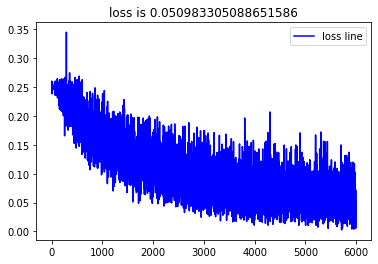

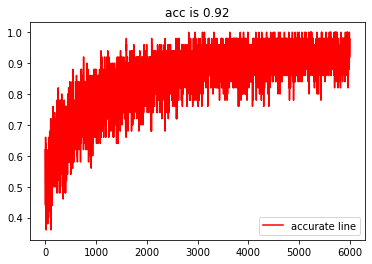

epoch is 199, acc_rate is 0.6, loss is 0.22471656993031502
epoch is 399, acc_rate is 0.76, loss is 0.20201698882505298
epoch is 599, acc_rate is 0.78, loss is 0.18315652481935105
epoch is 799, acc_rate is 0.88, loss is 0.11187161609108444
epoch is 999, acc_rate is 0.7, loss is 0.16432861461420545
epoch is 1199, acc_rate is 0.84, loss is 0.10369760059992132
epoch is 1399, acc_rate is 0.8, loss is 0.1227983070969276
epoch is 1599, acc_rate is 0.92, loss is 0.08396947235267974
epoch is 1799, acc_rate is 0.94, loss is 0.04476398835946185
epoch is 1999, acc_rate is 0.84, loss is 0.1143196807192021
epoch is 2199, acc_rate is 0.9, loss is 0.0532336974380459
epoch is 2399, acc_rate is 0.94, loss is 0.0618728909979615
epoch is 2599, acc_rate is 0.92, loss is 0.06737027672132498
epoch is 2799, acc_rate is 0.96, loss is 0.03401570937369932
epoch is 2999, acc_rate is 0.82, loss is 0.1065612905050749
epoch is 3199, acc_rate is 0.92, loss is 0.061950478903952846
epoch is 3399, acc_rate is 0.94, loss

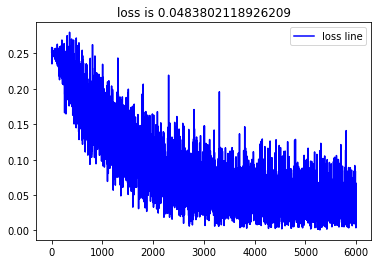

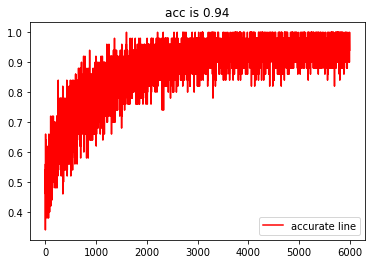

epoch is 199, acc_rate is 0.56, loss is 0.2353697408735752
epoch is 399, acc_rate is 0.66, loss is 0.2064827810926363
epoch is 599, acc_rate is 0.76, loss is 0.19343460044212407
epoch is 799, acc_rate is 0.88, loss is 0.11328186066537455
epoch is 999, acc_rate is 0.82, loss is 0.14840646845288574
epoch is 1199, acc_rate is 0.82, loss is 0.12571983250019458
epoch is 1399, acc_rate is 0.76, loss is 0.12262315642649156
epoch is 1599, acc_rate is 0.86, loss is 0.08256942035208852
epoch is 1799, acc_rate is 0.94, loss is 0.032835722253236097
epoch is 1999, acc_rate is 0.9, loss is 0.08070124978246625
epoch is 2199, acc_rate is 0.9, loss is 0.07315004984665657
epoch is 2399, acc_rate is 0.98, loss is 0.026628656682711055
epoch is 2599, acc_rate is 0.98, loss is 0.025126191483514138
epoch is 2799, acc_rate is 1.0, loss is 0.01086340013974906
epoch is 2999, acc_rate is 0.98, loss is 0.02406685482887181
epoch is 3199, acc_rate is 0.94, loss is 0.03316366451847621
epoch is 3399, acc_rate is 0.96

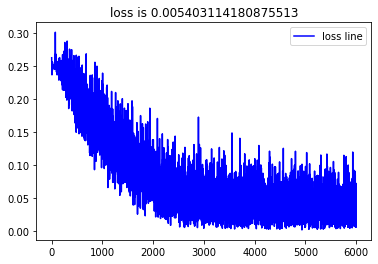

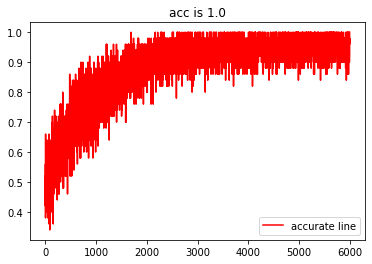

epoch is 199, acc_rate is 0.54, loss is 0.23502160772681235
epoch is 399, acc_rate is 0.66, loss is 0.24417186371982097
epoch is 599, acc_rate is 0.62, loss is 0.22709550481289625
epoch is 799, acc_rate is 0.78, loss is 0.13621587362898283
epoch is 999, acc_rate is 0.72, loss is 0.16396144585683942
epoch is 1199, acc_rate is 0.84, loss is 0.1315166274823423
epoch is 1399, acc_rate is 0.88, loss is 0.10504170992353465
epoch is 1599, acc_rate is 0.84, loss is 0.10188283049650852
epoch is 1799, acc_rate is 0.9, loss is 0.05413559231417636
epoch is 1999, acc_rate is 0.96, loss is 0.046308233621543876
epoch is 2199, acc_rate is 0.96, loss is 0.02707520502952132
epoch is 2399, acc_rate is 0.92, loss is 0.055247669551017155
epoch is 2599, acc_rate is 0.94, loss is 0.04454924807767222
epoch is 2799, acc_rate is 1.0, loss is 0.007985136582605419
epoch is 2999, acc_rate is 0.94, loss is 0.030160089128703785
epoch is 3199, acc_rate is 1.0, loss is 0.005783866112346644
epoch is 3399, acc_rate is 0

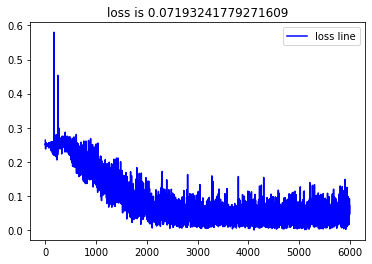

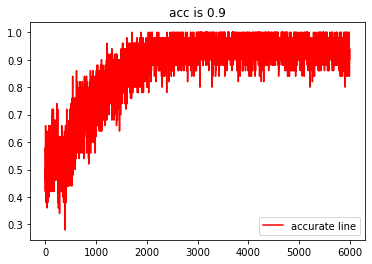

In [ ]:
from tqdm.notebook import tnrange, tqdm_notebook

for hidden_layer in [20, 50, 100, 200, 500]:
    # input layer, hidden_layer, output_layer, hidden_number
    lstm1 = LSTM1(50, hidden_layer, 1, 1, ishidden=False).cuda()
    lstm1_optimizer = optim.Adam(lstm1.parameters(), lr = 0.001)

    # loss function
    loss_function = nn.MSELoss()

    # init acc
    acc = 0

    # batch size
    batch_size = 50

    # list
    epoch_list = []
    loss_list = []
    acc_rate_list = []

    for ep in tnrange(6000):

        acc = 0
        loss_total = 0

        for i in range(batch_size):

            # t
            t = (ep * batch_size + i) % 25000

            # initial hidden layer
            h_0, s_0 = lstm1.initHiddenState()
            # initial learnable parameters
            lstm1.zero_grad()

            input = glove[[id2word[id] for id in X_train_numpy_clean[t]]].cuda()
            output = lstm1(input, h_0, s_0)
            
            loss = loss_function(output, Y_train[t].view(1))
            # print((output.size(), Y_train[i].view(1).size()))
            loss.backward()
            nn.utils.clip_grad_norm_(lstm1.parameters(), 5)
            lstm1_optimizer.step()

            # calculate accurate rate and loss
            pred = np.round(output.cpu().detach().numpy())
            if pred[0] == Y_train[t].cpu().detach().numpy():
                acc += 1
            loss_total += loss.cpu().detach().item()
        
        acc_rate = acc / batch_size
        loss_rate = loss_total / batch_size
        if (ep + 1) % 200 == 0:
            print(f"epoch is {ep}, acc_rate is {acc_rate}, loss is {loss_rate}")

        epoch_list.append(ep)
        loss_list.append(loss_rate)
        acc_rate_list.append(acc_rate)

    fig, ax = plt.subplots()
    sns.lineplot(x=epoch_list, y=loss_list, color='blue', label='loss line', ax=ax)
    plt.title(f"loss is {loss_rate}")
    plt.show()

    fig, ax = plt.subplots()
    sns.lineplot(x=epoch_list, y=acc_rate_list, color='red', label='accurate line', ax=ax)
    plt.title(f"acc is {acc_rate}")
    plt.show()


    path = '/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/LSTM_package_unidir_1hid_0dropout_' \
    + str(hidden_layer) + '.pt'
    torch.save(lstm1.state_dict(), path)


reload and test

In [ ]:
import torch
from tqdm.notebook import tnrange, tqdm_notebook

loss_function = nn.MSELoss()
N_test = 25000
epochs = 1

for hidden_layer in [20, 50, 100, 200, 500]:

    # reload hidden layer
    path = f'/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/LSTM_package_unidir_1hid_0dropout_{hidden_layer}.pt'
    lstm1 = LSTM1(50, hidden_layer, 1, 1, ishidden=False).cuda()
    lstm1.load_state_dict(torch.load(path))
    # lstm1.eval()

    # test
    acc_rate_test = 0
    loss_rate_test = 0
    for ep in range(epochs):
        acc_test = 0
        loss_test = 0
        for t in tnrange(N_test):
            input = glove[[id2word[id] for id in X_test_numpy_clean[t]]].cuda()
            h_0, s_0 = lstm1.initHiddenState()
            output = lstm1(input, h_0, s_0)
            loss = loss_function(output, Y_test[t].cuda().view(1))
            loss_test += loss.detach() # avoid memory leak, you need to add detach()
            pred_test = np.round(output.cpu().detach().numpy())
            if pred_test[0] == Y_test[t].cpu().detach().numpy():
                acc_test += 1
            
        acc_rate_test += acc_test / N_test
        loss_rate_test += loss_test / N_test
    acc_rate_test = acc_rate_test / epochs
    loss_rate_test = loss_rate_test / epochs
    print(f"hidden layer is {hidden_layer}: loss is {loss_rate_test}, acc_rate is {acc_rate_test}")



hidden layer is 20: loss is 0.16860508918762207, acc_rate is 0.77088



hidden layer is 50: loss is 0.18430651724338531, acc_rate is 0.76968



hidden layer is 100: loss is 0.19897985458374023, acc_rate is 0.76012



hidden layer is 200: loss is 0.19271278381347656, acc_rate is 0.7636



hidden layer is 500: loss is 0.20509617030620575, acc_rate is 0.74948


**unidirectional, 2 hidden layer, dropout 0**
--------------------
train

epoch is 199, acc_rate is 0.64, loss is 0.23355152025818826
epoch is 399, acc_rate is 0.72, loss is 0.18522183045744897
epoch is 599, acc_rate is 0.7, loss is 0.18672028651693837
epoch is 799, acc_rate is 0.78, loss is 0.15515885975793936
epoch is 999, acc_rate is 0.76, loss is 0.15164988562930376
epoch is 1199, acc_rate is 0.78, loss is 0.14339453199934724
epoch is 1399, acc_rate is 0.82, loss is 0.14273274208451767
epoch is 1599, acc_rate is 0.84, loss is 0.10813946674278284
epoch is 1799, acc_rate is 0.8, loss is 0.12437864241152057
epoch is 1999, acc_rate is 0.82, loss is 0.12996071983636284
epoch is 2199, acc_rate is 0.82, loss is 0.1262085757173395
epoch is 2399, acc_rate is 0.84, loss is 0.10825835662128919
epoch is 2599, acc_rate is 0.86, loss is 0.08188532632996327
epoch is 2799, acc_rate is 0.82, loss is 0.10663345056713283
epoch is 2999, acc_rate is 0.86, loss is 0.11528858416925232
epoch is 3199, acc_rate is 0.84, loss is 0.09748740087917021
epoch is 3399, acc_rate is 0.84,

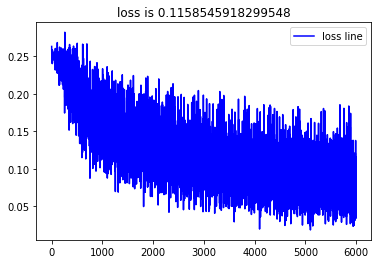

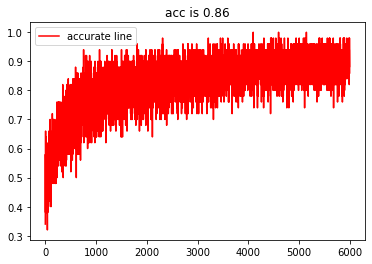

epoch is 199, acc_rate is 0.58, loss is 0.23119449317455293
epoch is 399, acc_rate is 0.74, loss is 0.1850843410109519
epoch is 599, acc_rate is 0.66, loss is 0.2350885594409192
epoch is 799, acc_rate is 0.82, loss is 0.11622170532484233
epoch is 999, acc_rate is 0.76, loss is 0.13900950228156944
epoch is 1199, acc_rate is 0.84, loss is 0.10822292439426874
epoch is 1399, acc_rate is 0.86, loss is 0.11392427653398045
epoch is 1599, acc_rate is 0.86, loss is 0.12057539859836985
epoch is 1799, acc_rate is 0.92, loss is 0.061613668776618086
epoch is 1999, acc_rate is 0.88, loss is 0.08142566599772585
epoch is 2199, acc_rate is 0.94, loss is 0.06376026229793245
epoch is 2399, acc_rate is 0.86, loss is 0.09328610269541812
epoch is 2599, acc_rate is 0.9, loss is 0.0719099602846938
epoch is 2799, acc_rate is 0.96, loss is 0.03649168233257212
epoch is 2999, acc_rate is 0.94, loss is 0.05230595907788995
epoch is 3199, acc_rate is 0.9, loss is 0.06595074992311564
epoch is 3399, acc_rate is 0.9, l

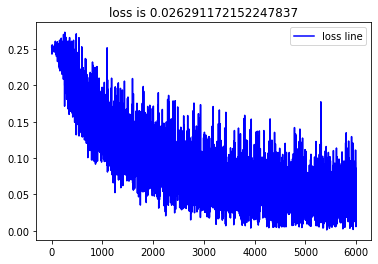

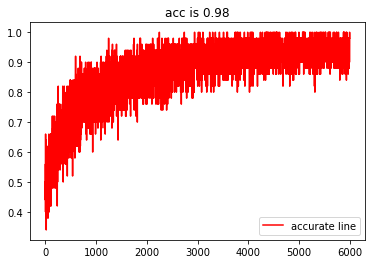

epoch is 199, acc_rate is 0.5, loss is 0.2404744927585125
epoch is 399, acc_rate is 0.76, loss is 0.18485492629930378
epoch is 599, acc_rate is 0.74, loss is 0.18572500950529444
epoch is 799, acc_rate is 0.84, loss is 0.10354097856747103
epoch is 999, acc_rate is 0.92, loss is 0.09846656627050834
epoch is 1199, acc_rate is 0.88, loss is 0.09673247574971562
epoch is 1399, acc_rate is 0.86, loss is 0.08605945184051735
epoch is 1599, acc_rate is 0.88, loss is 0.08276533053142227
epoch is 1799, acc_rate is 0.9, loss is 0.06554892066257345
epoch is 1999, acc_rate is 0.96, loss is 0.0488180474418008
epoch is 2199, acc_rate is 0.94, loss is 0.04775519778757575
epoch is 2399, acc_rate is 0.9, loss is 0.0698761580719352
epoch is 2599, acc_rate is 0.98, loss is 0.01898724566850931
epoch is 2799, acc_rate is 0.94, loss is 0.03507084344739941
epoch is 2999, acc_rate is 0.96, loss is 0.0352318687458342
epoch is 3199, acc_rate is 0.92, loss is 0.06075577064453945
epoch is 3399, acc_rate is 1.0, loss

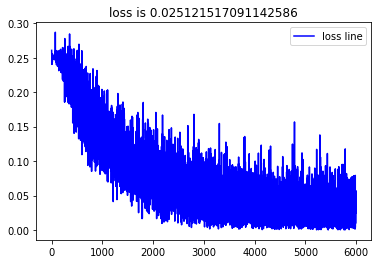

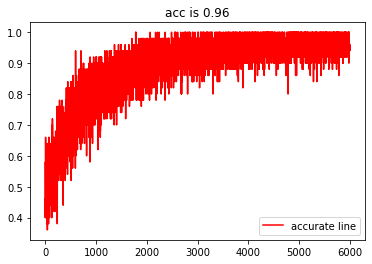

epoch is 199, acc_rate is 0.5, loss is 0.24344592466950415
epoch is 399, acc_rate is 0.64, loss is 0.2395961929857731
epoch is 599, acc_rate is 0.44, loss is 0.2520057858712971
epoch is 799, acc_rate is 0.8, loss is 0.16533711045747623
epoch is 999, acc_rate is 0.74, loss is 0.18320408574538305
epoch is 1199, acc_rate is 0.66, loss is 0.17514066327474212
epoch is 1399, acc_rate is 0.84, loss is 0.11766318539866455
epoch is 1599, acc_rate is 0.84, loss is 0.09506025734114903
epoch is 1799, acc_rate is 0.9, loss is 0.06642644375679833
epoch is 1999, acc_rate is 0.8, loss is 0.13727638470576495
epoch is 2199, acc_rate is 0.86, loss is 0.08850926857335206
epoch is 2399, acc_rate is 0.88, loss is 0.08733940993861325
epoch is 2599, acc_rate is 0.98, loss is 0.03526295341649102
epoch is 2799, acc_rate is 0.96, loss is 0.03316801067313225
epoch is 2999, acc_rate is 0.9, loss is 0.06958316814790132
epoch is 3199, acc_rate is 0.9, loss is 0.07058503830266921
epoch is 3399, acc_rate is 0.9, loss 

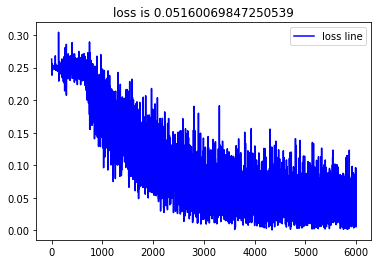

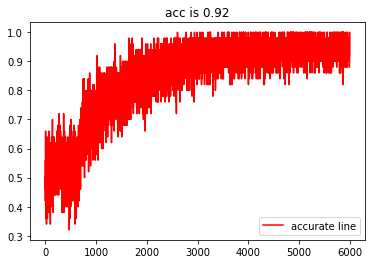

epoch is 199, acc_rate is 0.54, loss is 0.2496657457947731
epoch is 399, acc_rate is 0.64, loss is 0.24027697414159774
epoch is 599, acc_rate is 0.6, loss is 0.2425360944867134
epoch is 799, acc_rate is 0.6, loss is 0.24124198919860645
epoch is 999, acc_rate is 0.5, loss is 0.25522521913051605
epoch is 1199, acc_rate is 0.54, loss is 0.2388877663583844
epoch is 1399, acc_rate is 0.64, loss is 0.25250445544719696
epoch is 1599, acc_rate is 0.56, loss is 0.23650755940005183
epoch is 1799, acc_rate is 0.64, loss is 0.22182875801308682
epoch is 1999, acc_rate is 0.54, loss is 0.24127369264140724
epoch is 2199, acc_rate is 0.6, loss is 0.20574052641633897
epoch is 2399, acc_rate is 0.62, loss is 0.23576963764615358
epoch is 2599, acc_rate is 0.56, loss is 0.24068248242139817
epoch is 2799, acc_rate is 0.68, loss is 0.21160651925443744
epoch is 2999, acc_rate is 0.64, loss is 0.21879574065096677
epoch is 3199, acc_rate is 0.7, loss is 0.18565590614205577
epoch is 3399, acc_rate is 0.62, loss

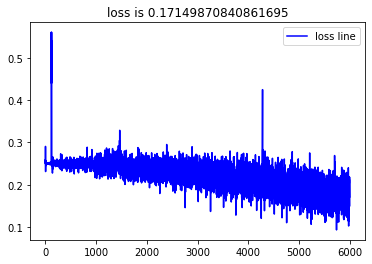

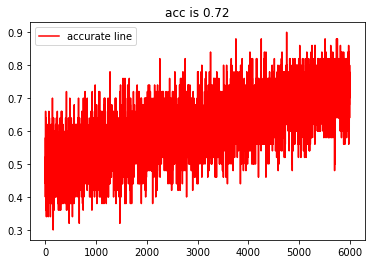

In [ ]:
from tqdm.notebook import tnrange, tqdm_notebook

for hidden_layer in [20, 50, 100, 200, 500]:
    # input layer, hidden_layer, output_layer, hidden_number
    lstm1 = LSTM1(50, hidden_layer, 1, 2, 0, ishidden=False).cuda()
    lstm1_optimizer = optim.Adam(lstm1.parameters(), lr = 0.001)

    # loss function
    loss_function = nn.MSELoss()

    # init acc
    acc = 0

    # batch size
    batch_size = 50

    # list
    epoch_list = []
    loss_list = []
    acc_rate_list = []

    for ep in tnrange(6000):

        acc = 0
        loss_total = 0

        for i in range(batch_size):

            # t
            t = (ep * batch_size + i) % 25000

            # initial hidden layer
            h_0, s_0 = lstm1.initHiddenState()
            # initial learnable parameters
            lstm1.zero_grad()

            input = glove[[id2word[id] for id in X_train_numpy_clean[t]]].cuda()
            output = lstm1(input, h_0, s_0)
            
            loss = loss_function(output, Y_train[t].view(1))
            # print((output.size(), Y_train[i].view(1).size()))
            loss.backward()
            nn.utils.clip_grad_norm_(lstm1.parameters(), 5)
            lstm1_optimizer.step()

            # calculate accurate rate and loss
            pred = np.round(output.cpu().detach().numpy())
            if pred[0] == Y_train[t].cpu().detach().numpy():
                acc += 1
            loss_total += loss.cpu().detach().item()
        
        acc_rate = acc / batch_size
        loss_rate = loss_total / batch_size
        if (ep + 1) % 200 == 0:
            print(f"epoch is {ep}, acc_rate is {acc_rate}, loss is {loss_rate}")

        epoch_list.append(ep)
        loss_list.append(loss_rate)
        acc_rate_list.append(acc_rate)

    fig, ax = plt.subplots()
    sns.lineplot(x=epoch_list, y=loss_list, color='blue', label='loss line', ax=ax)
    plt.title(f"loss is {loss_rate}")
    plt.show()

    fig, ax = plt.subplots()
    sns.lineplot(x=epoch_list, y=acc_rate_list, color='red', label='accurate line', ax=ax)
    plt.title(f"acc is {acc_rate}")
    plt.show()


    path = '/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/LSTM_package_unidir_2hid_0dropout_' \
    + str(hidden_layer) + '.pt'
    torch.save(lstm1.state_dict(), path)

reload and test

In [ ]:
import torch
from tqdm.notebook import tnrange, tqdm_notebook

loss_function = nn.MSELoss()
N_test = 25000
epochs = 1

for hidden_layer in [20, 50, 100, 200, 500]:

    # reload hidden layer
    path = f'/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/LSTM_package_unidir_2hid_0dropout_{hidden_layer}.pt'
    lstm1 = LSTM1(50, hidden_layer, 1, 2, ishidden=False).cuda()
    lstm1.load_state_dict(torch.load(path))
    # lstm1.eval()

    # test
    acc_rate_test = 0
    loss_rate_test = 0
    for ep in tnrange(epochs):
        acc_test = 0
        loss_test = 0
        for t in range(N_test):
            input = glove[[id2word[id] for id in X_test_numpy_clean[t]]].cuda()
            h_0, s_0 = lstm1.initHiddenState()
            output = lstm1(input, h_0, s_0)
            loss = loss_function(output, Y_test[t].cuda().view(1))
            loss_test += loss.detach() # avoid memory leak
            pred_test = np.round(output.cpu().detach().numpy())
            if pred_test[0] == Y_test[t].cpu().detach().numpy():
                acc_test += 1
            
        acc_rate_test += acc_test / N_test
        loss_rate_test += loss_test / N_test
    acc_rate_test = acc_rate_test / epochs
    loss_rate_test = loss_rate_test / epochs
    print(f"hidden layer is {hidden_layer}: loss is {loss_rate_test}, acc_rate is {acc_rate_test}")


hidden layer is 20: loss is 0.16743320226669312, acc_rate is 0.78764



hidden layer is 50: loss is 0.18363620340824127, acc_rate is 0.78208



hidden layer is 100: loss is 0.16734915971755981, acc_rate is 0.79864



hidden layer is 200: loss is 0.18780530989170074, acc_rate is 0.7718



hidden layer is 500: loss is 0.28200942277908325, acc_rate is 0.57496


**unidirectional, 2 hidden layer, dropout 0.4**
--------------------
train

epoch is 199, acc_rate is 0.64, loss is 0.22894828408956527
epoch is 399, acc_rate is 0.74, loss is 0.19742296006530524
epoch is 599, acc_rate is 0.68, loss is 0.20168484317604451
epoch is 799, acc_rate is 0.8, loss is 0.13845393522307858
epoch is 999, acc_rate is 0.82, loss is 0.1564015510943136
epoch is 1199, acc_rate is 0.74, loss is 0.1539558372930128
epoch is 1399, acc_rate is 0.82, loss is 0.13187236043761175
epoch is 1599, acc_rate is 0.88, loss is 0.10553491407964159
epoch is 1799, acc_rate is 0.8, loss is 0.11022674264440865
epoch is 1999, acc_rate is 0.82, loss is 0.1271974724827851
epoch is 2199, acc_rate is 0.78, loss is 0.14519691794164472
epoch is 2399, acc_rate is 0.82, loss is 0.1250176452120943
epoch is 2599, acc_rate is 0.9, loss is 0.09368251822127259
epoch is 2799, acc_rate is 0.88, loss is 0.09815901519263662
epoch is 2999, acc_rate is 0.84, loss is 0.10936765555119109
epoch is 3199, acc_rate is 0.84, loss is 0.13810870002087694
epoch is 3399, acc_rate is 0.86, los

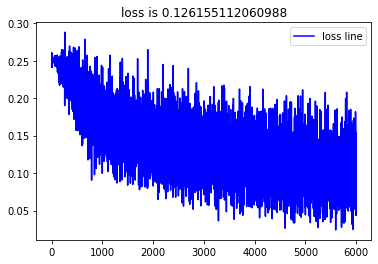

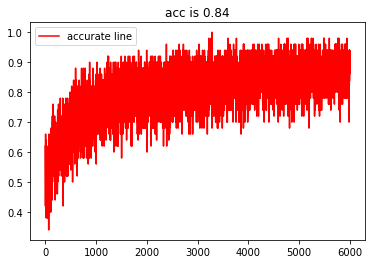

epoch is 199, acc_rate is 0.6, loss is 0.23277321219444275
epoch is 399, acc_rate is 0.74, loss is 0.21861396453343332
epoch is 599, acc_rate is 0.78, loss is 0.17251787859987416
epoch is 799, acc_rate is 0.8, loss is 0.12016274260491172
epoch is 999, acc_rate is 0.76, loss is 0.1505121087943553
epoch is 1199, acc_rate is 0.88, loss is 0.10629880339902002
epoch is 1399, acc_rate is 0.82, loss is 0.13178317289302868
epoch is 1599, acc_rate is 0.92, loss is 0.09113264445689354
epoch is 1799, acc_rate is 0.88, loss is 0.08838065035531997
epoch is 1999, acc_rate is 0.82, loss is 0.12612160213300086
epoch is 2199, acc_rate is 0.92, loss is 0.07624594473417284
epoch is 2399, acc_rate is 0.86, loss is 0.09953927831256695
epoch is 2599, acc_rate is 0.94, loss is 0.053177803934801454
epoch is 2799, acc_rate is 0.94, loss is 0.04864078971907951
epoch is 2999, acc_rate is 0.84, loss is 0.10521356862326499
epoch is 3199, acc_rate is 0.92, loss is 0.0619108478182267
epoch is 3399, acc_rate is 0.82,

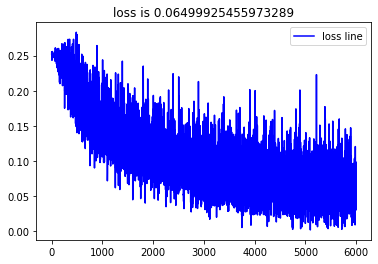

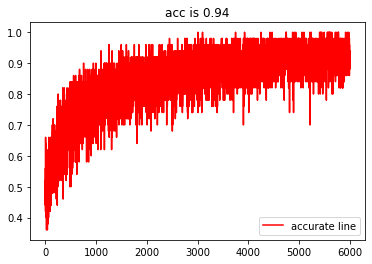

epoch is 199, acc_rate is 0.58, loss is 0.2352189315855503
epoch is 399, acc_rate is 0.68, loss is 0.22402933722361923
epoch is 599, acc_rate is 0.72, loss is 0.1929075039527379
epoch is 799, acc_rate is 0.82, loss is 0.12084134069853462
epoch is 999, acc_rate is 0.78, loss is 0.13470060508981987
epoch is 1199, acc_rate is 0.84, loss is 0.11803206690329489
epoch is 1399, acc_rate is 0.84, loss is 0.12750784847997632
epoch is 1599, acc_rate is 0.9, loss is 0.06992003489012485
epoch is 1799, acc_rate is 0.9, loss is 0.08940126474086128
epoch is 1999, acc_rate is 0.88, loss is 0.09197274158041636
epoch is 2199, acc_rate is 0.88, loss is 0.09260427607017721
epoch is 2399, acc_rate is 0.88, loss is 0.09326803587076185
epoch is 2599, acc_rate is 0.92, loss is 0.06307236938555615
epoch is 2799, acc_rate is 0.96, loss is 0.037368982231061165
epoch is 2999, acc_rate is 0.94, loss is 0.05478286729527174
epoch is 3199, acc_rate is 0.9, loss is 0.06436083405877233
epoch is 3399, acc_rate is 0.9, l

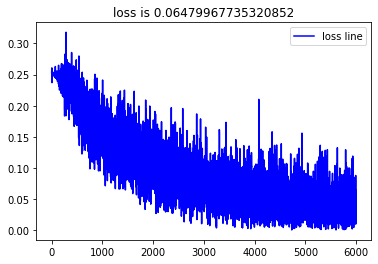

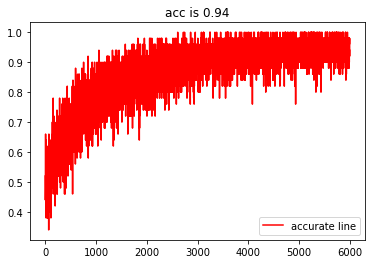

epoch is 199, acc_rate is 0.54, loss is 0.24916602402925492
epoch is 399, acc_rate is 0.64, loss is 0.2485933358967304
epoch is 599, acc_rate is 0.62, loss is 0.2423722642660141
epoch is 799, acc_rate is 0.6, loss is 0.24077944464981557
epoch is 999, acc_rate is 0.68, loss is 0.21711604040116073
epoch is 1199, acc_rate is 0.7, loss is 0.21035316539928317
epoch is 1399, acc_rate is 0.76, loss is 0.16971864978084342
epoch is 1599, acc_rate is 0.72, loss is 0.191561360669275
epoch is 1799, acc_rate is 0.78, loss is 0.13446218209923244
epoch is 1999, acc_rate is 0.82, loss is 0.13065469747223687
epoch is 2199, acc_rate is 0.76, loss is 0.13373641737743128
epoch is 2399, acc_rate is 0.84, loss is 0.11604050703785901
epoch is 2599, acc_rate is 0.88, loss is 0.07510962869748783
epoch is 2799, acc_rate is 0.86, loss is 0.10256504157375666
epoch is 2999, acc_rate is 0.84, loss is 0.12518029007681583
epoch is 3199, acc_rate is 0.88, loss is 0.08746899724882785
epoch is 3399, acc_rate is 0.86, lo

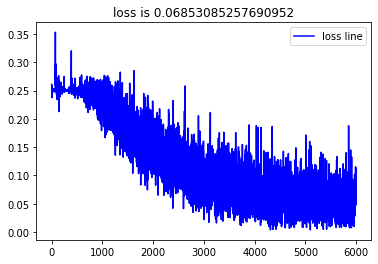

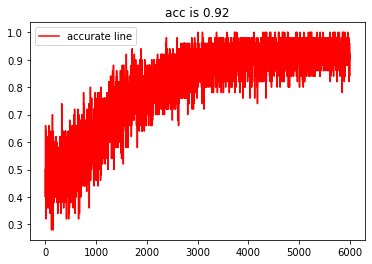

epoch is 199, acc_rate is 0.52, loss is 0.2524287340044975
epoch is 399, acc_rate is 0.64, loss is 0.24831929981708525
epoch is 599, acc_rate is 0.56, loss is 0.2489216786623001
epoch is 799, acc_rate is 0.62, loss is 0.2344566598534584
epoch is 999, acc_rate is 0.54, loss is 0.24223172724246977
epoch is 1199, acc_rate is 0.56, loss is 0.23264838131144644
epoch is 1399, acc_rate is 0.64, loss is 0.24594461880624294
epoch is 1599, acc_rate is 0.58, loss is 0.22686610896140336
epoch is 1799, acc_rate is 0.72, loss is 0.2191114751738496
epoch is 1999, acc_rate is 0.58, loss is 0.23029792323708534
epoch is 2199, acc_rate is 0.6, loss is 0.20312918075243944
epoch is 2399, acc_rate is 0.6, loss is 0.2280307786911726
epoch is 2599, acc_rate is 0.62, loss is 0.2253003346190519
epoch is 2799, acc_rate is 0.72, loss is 0.2307773843083487
epoch is 2999, acc_rate is 0.62, loss is 0.21385441165417432
epoch is 3199, acc_rate is 0.64, loss is 0.18733922101627967
epoch is 3399, acc_rate is 0.62, loss 

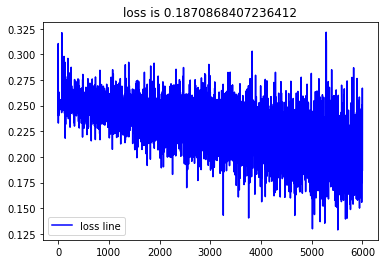

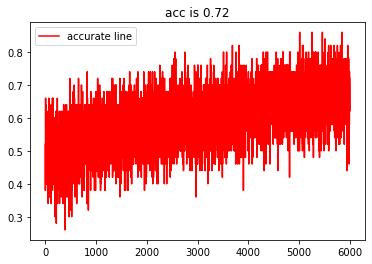

In [ ]:
from tqdm.notebook import tnrange, tqdm_notebook

for hidden_layer in [20, 50, 100, 200, 500]:
    # input layer, hidden_layer, output_layer, hidden_number
    lstm1 = LSTM1(50, hidden_layer, 1, 2, 0.4, ishidden=False).cuda()
    lstm1_optimizer = optim.Adam(lstm1.parameters(), lr = 0.001)

    # loss function
    loss_function = nn.MSELoss()

    # init acc
    acc = 0

    # batch size
    batch_size = 50

    # list
    epoch_list = []
    loss_list = []
    acc_rate_list = []

    for ep in tnrange(6000):

        acc = 0
        loss_total = 0

        for i in range(batch_size):

            # t
            t = (ep * batch_size + i) % 25000

            # initial hidden layer
            h_0, s_0 = lstm1.initHiddenState()
            # initial learnable parameters
            lstm1.zero_grad()

            input = glove[[id2word[id] for id in X_train_numpy_clean[t]]].cuda()
            output = lstm1(input, h_0, s_0)
            
            loss = loss_function(output, Y_train[t].view(1))
            # print((output.size(), Y_train[i].view(1).size()))
            loss.backward()
            nn.utils.clip_grad_norm_(lstm1.parameters(), 5)
            lstm1_optimizer.step()

            # calculate accurate rate and loss
            pred = np.round(output.cpu().detach().numpy())
            if pred[0] == Y_train[t].cpu().detach().numpy():
                acc += 1
            loss_total += loss.cpu().detach().item()
        
        acc_rate = acc / batch_size
        loss_rate = loss_total / batch_size
        if (ep + 1) % 200 == 0:
            print(f"epoch is {ep}, acc_rate is {acc_rate}, loss is {loss_rate}")

        epoch_list.append(ep)
        loss_list.append(loss_rate)
        acc_rate_list.append(acc_rate)

    fig, ax = plt.subplots()
    sns.lineplot(x=epoch_list, y=loss_list, color='blue', label='loss line', ax=ax)
    plt.title(f"loss is {loss_rate}")
    plt.show()

    fig, ax = plt.subplots()
    sns.lineplot(x=epoch_list, y=acc_rate_list, color='red', label='accurate line', ax=ax)
    plt.title(f"acc is {acc_rate}")
    plt.show()


    path = '/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/LSTM_package_unidir_2hid_04dropout_' \
    + str(hidden_layer) + '.pt'
    torch.save(lstm1.state_dict(), path)

reload and test

In [18]:
import torch
from tqdm.notebook import tnrange, tqdm_notebook

loss_function = nn.MSELoss()
N_test = 25000
epochs = 1

for hidden_layer in [20, 50, 100, 200, 500]:

    # reload hidden layer
    path = f'/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/LSTM_package_unidir_2hid_04dropout_{hidden_layer}.pt'
    lstm1 = LSTM1(50, hidden_layer, 1, 2, ishidden=False).cuda()
    lstm1.load_state_dict(torch.load(path))
    # lstm1.eval()

    # test
    acc_rate_test = 0
    loss_rate_test = 0
    for ep in tnrange(epochs):
        acc_test = 0
        loss_test = 0
        for t in range(N_test):
            input = glove[[id2word[id] for id in X_test_numpy_clean[t]]].cuda()
            h_0, s_0 = lstm1.initHiddenState()
            output = lstm1(input, h_0, s_0)
            loss = loss_function(output, Y_test[t].cuda().view(1))
            loss_test += loss.detach() # avoid memory leak
            pred_test = np.round(output.cpu().detach().numpy())
            if pred_test[0] == Y_test[t].cpu().detach().numpy():
                acc_test += 1
            
        acc_rate_test += acc_test / N_test
        loss_rate_test += loss_test / N_test
    acc_rate_test = acc_rate_test / epochs
    loss_rate_test = loss_rate_test / epochs
    print(f"hidden layer is {hidden_layer}: loss is {loss_rate_test}, acc_rate is {acc_rate_test}")


hidden layer is 20: loss is 0.1741410493850708, acc_rate is 0.76628



hidden layer is 50: loss is 0.18448875844478607, acc_rate is 0.7762



hidden layer is 100: loss is 0.19927425682544708, acc_rate is 0.76356



hidden layer is 200: loss is 0.17730125784873962, acc_rate is 0.77716



hidden layer is 500: loss is 0.2630729377269745, acc_rate is 0.57788


**bidirectional, 1 hidden layer, dropout 0**
--------------------
train


epoch is 199, acc_rate is 0.68, loss is 0.22593446403741838
epoch is 399, acc_rate is 0.78, loss is 0.18521859101951121
epoch is 599, acc_rate is 0.66, loss is 0.19714723559794947
epoch is 799, acc_rate is 0.88, loss is 0.1130775489149255
epoch is 999, acc_rate is 0.84, loss is 0.13337847088463606
epoch is 1199, acc_rate is 0.86, loss is 0.10939786595006354
epoch is 1399, acc_rate is 0.88, loss is 0.10006875702954858
epoch is 1599, acc_rate is 0.86, loss is 0.11750157396379109
epoch is 1799, acc_rate is 0.88, loss is 0.0895778165085133
epoch is 1999, acc_rate is 0.84, loss is 0.0934499270462402
epoch is 2199, acc_rate is 0.86, loss is 0.08400845489478379
epoch is 2399, acc_rate is 0.9, loss is 0.07763445213222198
epoch is 2599, acc_rate is 0.88, loss is 0.09840609809613028
epoch is 2799, acc_rate is 0.92, loss is 0.05392969982788131
epoch is 2999, acc_rate is 0.88, loss is 0.08619498030088436
epoch is 3199, acc_rate is 0.92, loss is 0.06757287622217639
epoch is 3399, acc_rate is 0.94, 

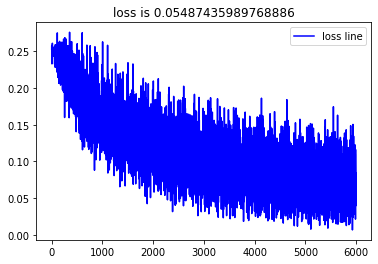

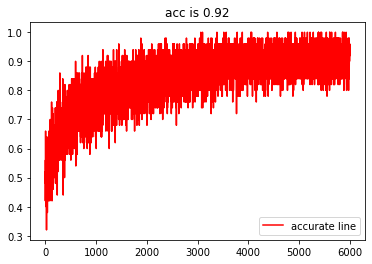

epoch is 199, acc_rate is 0.66, loss is 0.21996852323412897
epoch is 399, acc_rate is 0.66, loss is 0.20877974577248096
epoch is 599, acc_rate is 0.72, loss is 0.18311901022549137
epoch is 799, acc_rate is 0.86, loss is 0.11846226096880855
epoch is 999, acc_rate is 0.84, loss is 0.12841995662485714
epoch is 1199, acc_rate is 0.9, loss is 0.10300928655406551
epoch is 1399, acc_rate is 0.82, loss is 0.1374875339188111
epoch is 1599, acc_rate is 0.9, loss is 0.09173322735705625
epoch is 1799, acc_rate is 0.92, loss is 0.06109814446503861
epoch is 1999, acc_rate is 0.88, loss is 0.09012302360716604
epoch is 2199, acc_rate is 0.94, loss is 0.050617773277515994
epoch is 2399, acc_rate is 0.9, loss is 0.09251090937078855
epoch is 2599, acc_rate is 0.94, loss is 0.03336627008603172
epoch is 2799, acc_rate is 0.9, loss is 0.055220672910587215
epoch is 2999, acc_rate is 0.94, loss is 0.053869612578936826
epoch is 3199, acc_rate is 0.94, loss is 0.046657646039562295
epoch is 3399, acc_rate is 0.9

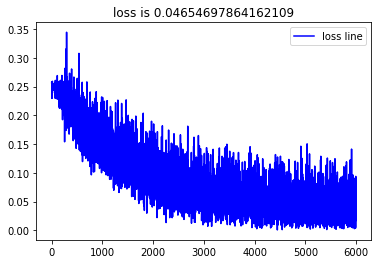

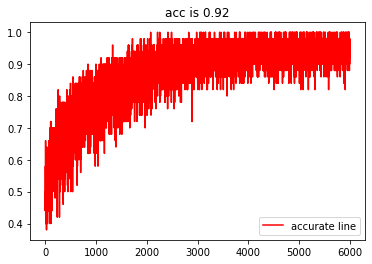

epoch is 199, acc_rate is 0.58, loss is 0.22338752165436745
epoch is 399, acc_rate is 0.74, loss is 0.17802746683242732
epoch is 599, acc_rate is 0.68, loss is 0.18302246877523431
epoch is 799, acc_rate is 0.88, loss is 0.09973514682904351
epoch is 999, acc_rate is 0.78, loss is 0.1269254098413512
epoch is 1199, acc_rate is 0.84, loss is 0.12199774502444484
epoch is 1399, acc_rate is 0.88, loss is 0.0923492421306318
epoch is 1599, acc_rate is 0.96, loss is 0.05204810510219381
epoch is 1799, acc_rate is 0.98, loss is 0.027754736149792764
epoch is 1999, acc_rate is 0.88, loss is 0.08119581376118162
epoch is 2199, acc_rate is 0.88, loss is 0.088287917122056
epoch is 2399, acc_rate is 0.9, loss is 0.05989880938857487
epoch is 2599, acc_rate is 0.94, loss is 0.037712430864298464
epoch is 2799, acc_rate is 0.94, loss is 0.05230881375366829
epoch is 2999, acc_rate is 0.94, loss is 0.0307495272704476
epoch is 3199, acc_rate is 0.94, loss is 0.036623424742994806
epoch is 3399, acc_rate is 1.0, 

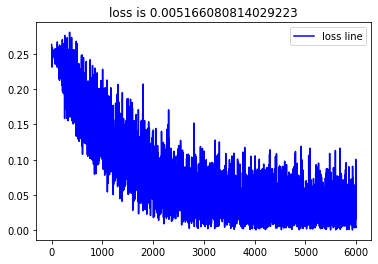

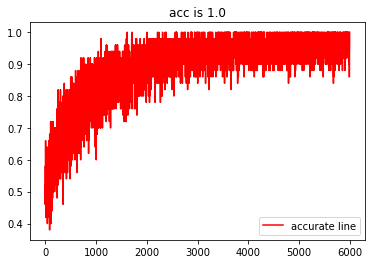

epoch is 199, acc_rate is 0.56, loss is 0.23412844225764273
epoch is 399, acc_rate is 0.66, loss is 0.21450667253229766
epoch is 599, acc_rate is 0.82, loss is 0.16750604556971666
epoch is 799, acc_rate is 0.8, loss is 0.1278236520698556
epoch is 999, acc_rate is 0.82, loss is 0.14158895523083628
epoch is 1199, acc_rate is 0.82, loss is 0.11055776322203827
epoch is 1399, acc_rate is 0.84, loss is 0.0885954667205263
epoch is 1599, acc_rate is 0.96, loss is 0.04419950336560356
epoch is 1799, acc_rate is 0.96, loss is 0.049676304801778384
epoch is 1999, acc_rate is 0.96, loss is 0.025963151910074728
epoch is 2199, acc_rate is 0.9, loss is 0.05414804291941568
epoch is 2399, acc_rate is 0.96, loss is 0.035363620342739883
epoch is 2599, acc_rate is 1.0, loss is 0.005869997897247272
epoch is 2799, acc_rate is 0.98, loss is 0.01757999742309221
epoch is 2999, acc_rate is 0.98, loss is 0.02035885698770785
epoch is 3199, acc_rate is 0.96, loss is 0.01614468487263116
epoch is 3399, acc_rate is 1.0

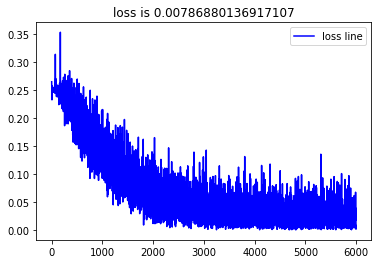

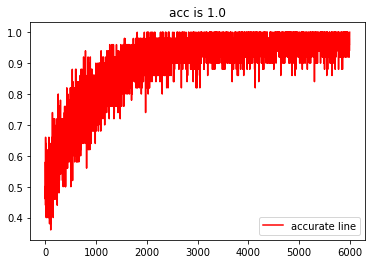

epoch is 199, acc_rate is 0.58, loss is 0.23812074452638626
epoch is 399, acc_rate is 0.72, loss is 0.2022601713053882
epoch is 599, acc_rate is 0.62, loss is 0.21344874269329012
epoch is 799, acc_rate is 0.82, loss is 0.12571843209836517
epoch is 999, acc_rate is 0.74, loss is 0.1565230172383599
epoch is 1199, acc_rate is 0.76, loss is 0.155666967878351
epoch is 1399, acc_rate is 0.86, loss is 0.0860193141698619
epoch is 1599, acc_rate is 0.88, loss is 0.08543671759603161
epoch is 1799, acc_rate is 0.94, loss is 0.04071851876665427
epoch is 1999, acc_rate is 0.9, loss is 0.08638665688006521
epoch is 2199, acc_rate is 0.96, loss is 0.03571677540271802
epoch is 2399, acc_rate is 0.96, loss is 0.030192392142244055
epoch is 2599, acc_rate is 0.96, loss is 0.03159483954776585
epoch is 2799, acc_rate is 0.96, loss is 0.014518681317827431
epoch is 2999, acc_rate is 0.94, loss is 0.05411983125827891
epoch is 3199, acc_rate is 0.96, loss is 0.01979606803000873
epoch is 3399, acc_rate is 1.0, l

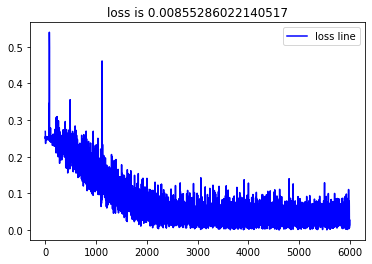

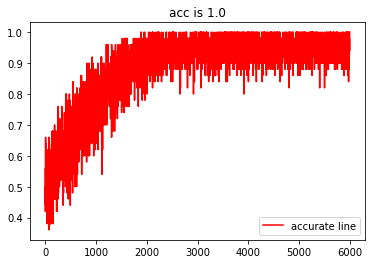

In [39]:
from tqdm.notebook import tnrange, tqdm_notebook

for hidden_layer in [20, 50, 100, 200, 500]:
    # input layer, hidden_layer, output_layer, hidden_number
    lstm1 = BiLSTM1(50, hidden_layer, 1, 1, ishidden=False).cuda()
    lstm1_optimizer = optim.Adam(lstm1.parameters(), lr = 0.001)

    # loss function
    loss_function = nn.MSELoss()

    # init acc
    acc = 0

    # batch size
    batch_size = 50

    # list
    epoch_list = []
    loss_list = []
    acc_rate_list = []

    for ep in tnrange(6000):

        acc = 0
        loss_total = 0

        for i in range(batch_size):

            # t
            t = (ep * batch_size + i) % 25000

            # initial hidden layer
            h_0, s_0 = lstm1.initHiddenState()
            # initial learnable parameters
            lstm1.zero_grad()

            input = glove[[id2word[id] for id in X_train_numpy_clean[t]]].cuda()
            output = lstm1(input, h_0, s_0)
            
            loss = loss_function(output, Y_train[t].view(1))
            # print((output.size(), Y_train[i].view(1).size()))
            loss.backward()
            nn.utils.clip_grad_norm_(lstm1.parameters(), 5)
            lstm1_optimizer.step()

            # calculate accurate rate and loss
            pred = np.round(output.cpu().detach().numpy())
            if pred[0] == Y_train[t].cpu().detach().numpy():
                acc += 1
            loss_total += loss.cpu().detach().item()
        
        acc_rate = acc / batch_size
        loss_rate = loss_total / batch_size
        if (ep + 1) % 200 == 0:
            print(f"epoch is {ep}, acc_rate is {acc_rate}, loss is {loss_rate}")

        epoch_list.append(ep)
        loss_list.append(loss_rate)
        acc_rate_list.append(acc_rate)

    fig, ax = plt.subplots()
    sns.lineplot(x=epoch_list, y=loss_list, color='blue', label='loss line', ax=ax)
    plt.title(f"loss is {loss_rate}")
    plt.show()

    fig, ax = plt.subplots()
    sns.lineplot(x=epoch_list, y=acc_rate_list, color='red', label='accurate line', ax=ax)
    plt.title(f"acc is {acc_rate}")
    plt.show()


    path = '/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/LSTM_package_bidir_1hid_0dropout_' \
    + str(hidden_layer) + '.pt'
    torch.save(lstm1.state_dict(), path)


In [43]:
import torch
from tqdm.notebook import tnrange, tqdm_notebook

loss_function = nn.MSELoss()
N_test = 25000
epochs = 1

for hidden_layer in [20, 50, 100, 200, 500]:

    # reload hidden layer
    path = f'/content/drive/My Drive/Colab Notebooks/AI_relative/algorithm_explore/pretrained_model/LSTM_package_bidir_1hid_0dropout_{hidden_layer}.pt'
    lstm1 = BiLSTM1(50, hidden_layer, 1, 1, ishidden=False).cuda()
    lstm1.load_state_dict(torch.load(path))
    # lstm1.eval()

    # test
    acc_rate_test = 0
    loss_rate_test = 0
    for ep in range(epochs):
        acc_test = 0
        loss_test = 0
        for t in tnrange(N_test):
            input = glove[[id2word[id] for id in X_test_numpy_clean[t]]].cuda()
            h_0, s_0 = lstm1.initHiddenState()
            output = lstm1(input, h_0, s_0)
            loss = loss_function(output, Y_test[t].cuda().view(1))
            loss_test += loss.detach() # avoid memory leak, you need to add detach()
            pred_test = np.round(output.cpu().detach().numpy())
            if pred_test[0] == Y_test[t].cpu().detach().numpy():
                acc_test += 1
            
        acc_rate_test += acc_test / N_test
        loss_rate_test += loss_test / N_test
    acc_rate_test = acc_rate_test / epochs
    loss_rate_test = loss_rate_test / epochs
    print(f"hidden layer is {hidden_layer}: loss is {loss_rate_test}, acc_rate is {acc_rate_test}")


hidden layer is 20: loss is 0.18368124961853027, acc_rate is 0.76848



hidden layer is 50: loss is 0.1941758543252945, acc_rate is 0.7664



hidden layer is 100: loss is 0.18139605224132538, acc_rate is 0.78232



hidden layer is 200: loss is 0.1834092140197754, acc_rate is 0.77784



hidden layer is 500: loss is 0.17575441300868988, acc_rate is 0.78164
